# Implicit gender stereotypes analysis
The last section of this project will assess if the stories contain stereotypical views on psychologically well-established traits by examining the association between pronouns and traits in the embedding space. 

In [1]:
import json
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from wefe.word_embedding_model import WordEmbeddingModel
from wefe.query import Query
from wefe.metrics import WEAT, RND
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [2]:
PATH = ''
TRAINED_MODEL_NAME = '4th_400_hst'
FILE_NAMES = ['h1-100', 's1-100', 't1-100', 'h101-200','s101-200', 't101-200',\
              'h201-300', 's201-300', 't201-300', 'h301-400', 's301-400', 't301-400']

In [3]:
attr_dict = json.load(open("attr_dict.json"))

tagged_attr = []
for i in attr_dict.keys():
    tagged_attr += attr_dict[i]

In [4]:
def read_data(path=PATH, file_names=FILE_NAMES):
    data = []
    for f_name in file_names:
        with open(path + f_name +'.txt') as f:
            file = f.read().replace('\n','').split('.')
            data += file
    return data

### 1 Wordclouds of selected attributes 
The wordclouds below compare the occurrence of the pre-defined traits among three gender types.
- **"Success" and "respected"** both share a high frequency since they are commonly used to describe someone at the top of the management ladder.
- **Male and female CEOs** have very **similar** proportions assigned to such traits. for example, they seem to be described equally concerning their "kindness" and "visionary". While for non-binary CEOs, their stories especially emphasize two extra words, "lead" and "respect".
- There are still many **non-binary CEOs**’ traits that are **relevant to their choice of pronouns**. They can be more "understanding", "respectful", and "supportive" to various social groups, and thus they make you feel "comfortable" to collaborate with. 

In [5]:
def get_freq_dict(data, tagged_attr):
    attr_freq = {}
    for sentence in data:
        # sentence = sentence.split()
        for attr in tagged_attr:
            if attr in sentence:
                attr_freq[attr] = attr_freq.get(attr, 0) + 1  
    return attr_freq

In [6]:
h_data = read_data(file_names=['h1-100', 'h101-200', 'h201-300', 'h301-400'])
s_data = read_data(file_names=['s1-100', 's101-200', 's201-300', 's301-400'])
t_data = read_data(file_names=['t1-100', 't101-200', 't201-300', 't301-400'])

h_dict = get_freq_dict(h_data, tagged_attr)
s_dict = get_freq_dict(s_data, tagged_attr)
t_dict = get_freq_dict(t_data, tagged_attr)

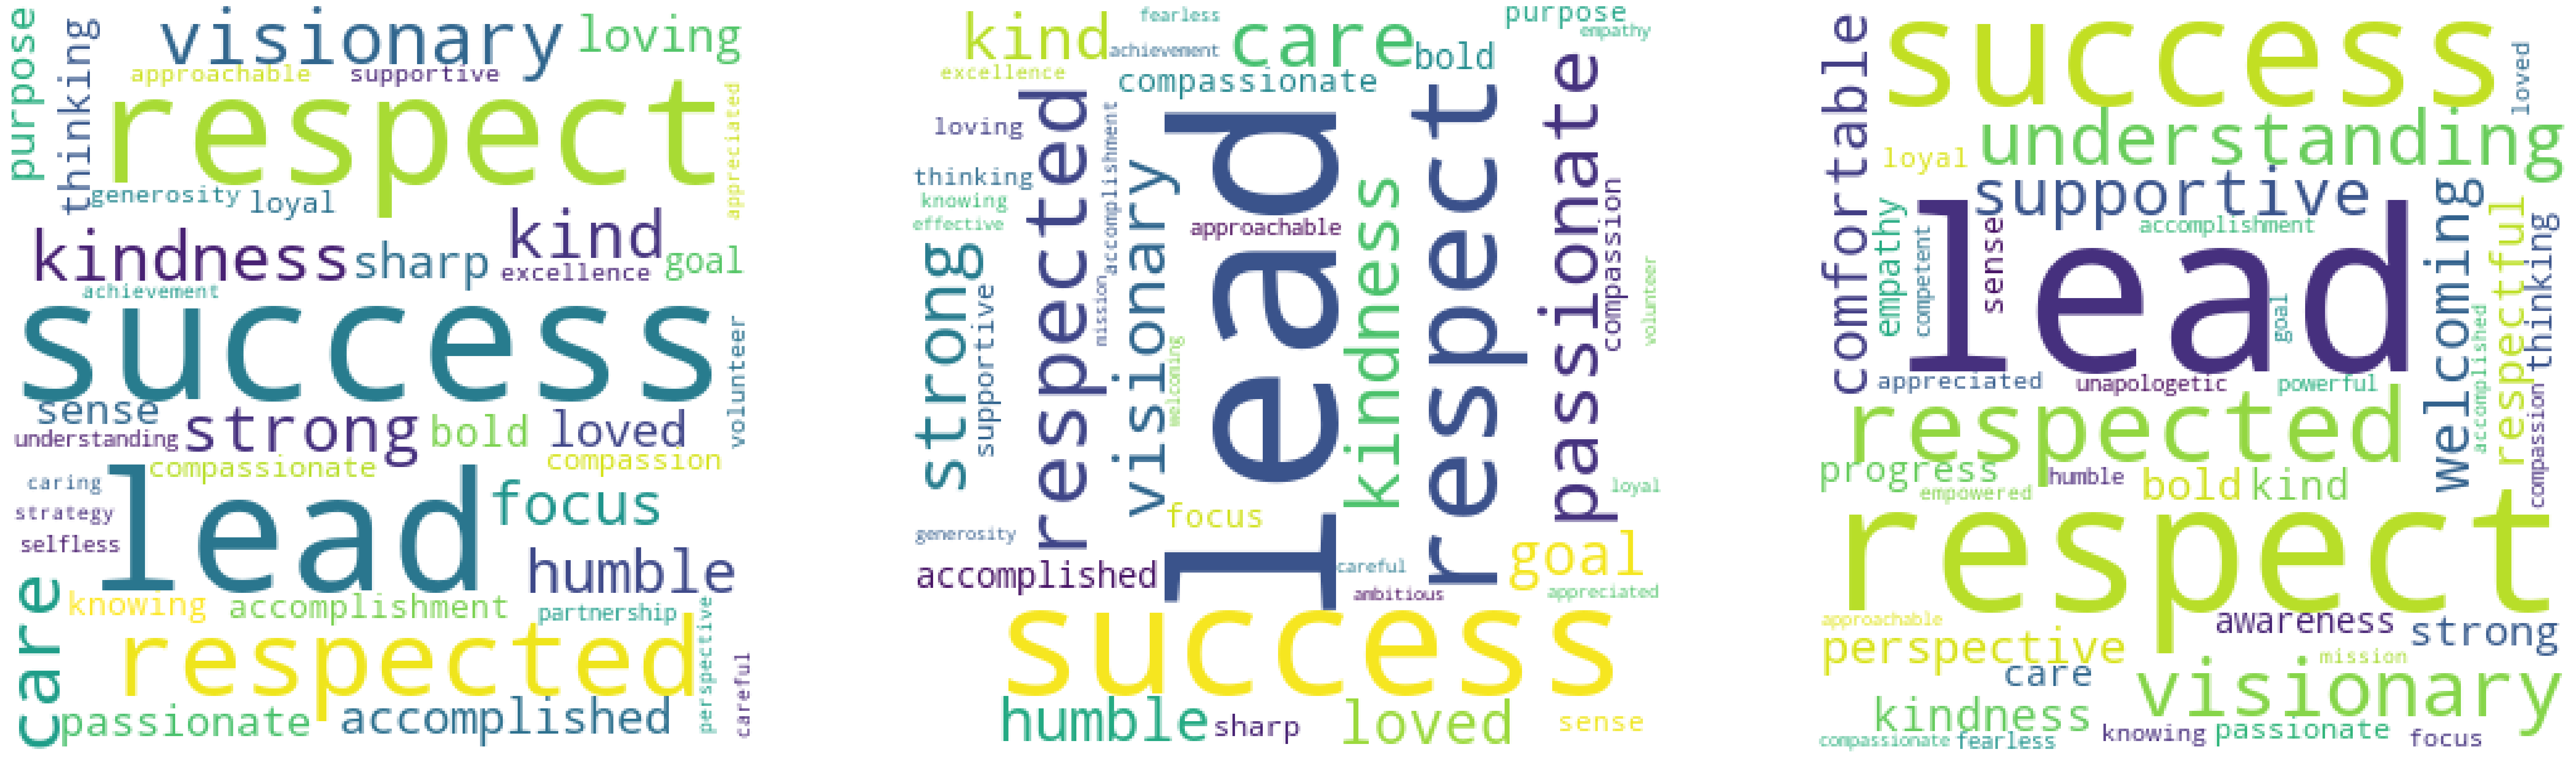

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(80, 80* 3))

for n,i in enumerate([h_dict, s_dict, t_dict]):
    wordcloud = WordCloud(width=300, height=300, background_color='white', max_words=40)\
                .generate_from_frequencies(frequencies=i)
    axs[n].imshow(wordcloud)
    axs[n].axis('off')

### 2 Gender-Trait Association

#### 2.1 the Word Embedding Association Test (WEAT)
[WEAT](https://www.science.org/doi/10.1126/science.aal4230) measures the strength of association between two sets of target words (T_1,T_2) and two sets of attribute words (A_1,A_2). In our context, there would be two sets of pronouns and two sets of traits. The null hypothesis states that there is no difference between two sets of target words concerning their relative similarity to the two sets of attribute words. The test statistic is 
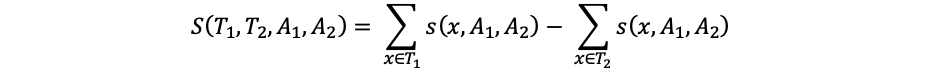with 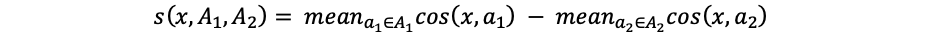quantifies the difference in similarity between a word and two attribute sets.

**The idea is that, the more positive the value of the test statistic, the more the target T_1 will related to trait A_1 and target T_2 will related to trait A_2. In the WEAT paper, the researcher also applied p-value and effect size to quantify statistical and substantive significance.**


Prior to measuring the similarity between pronouns and traits, it’s necessary to **exclude less frequent words** since their embeddings can be inaccurate. The rule here is to select traits that occur **more than 10 times** with a similarity to example words **higher than 0.45**. As shown in the barplot below, the size of these groups is not comparable; for example, only 3 words are in the group "Autonomy”, but 15 words are in the group "Concern for others". This has no bearing on the evaluation because the Word Embedding Association Test averages within-group cosine similarities before subtracting with the other group. Another thing should be mentioned here is that some of the chosen words are wrongly categorized as trait-related nouns or adjectives, like "achieved", "dominated", "strive", etc. Such words were manually removed before assessment.

In [8]:
attr_sim = json.load(open("attr_sim.json"))

data = read_data()
freq_dict = get_freq_dict(data, tagged_attr)

In [9]:
less_freq_attr = [key for key,val in freq_dict.items() if val < 10]
low_sim_attr = [key for key, val in attr_sim.items() if val < 0.45]
remove_attr = list(set(less_freq_attr) | set(low_sim_attr))

len(remove_attr)

95

In [10]:
attr_dict_s = {}

for k in attr_dict.keys():
    l = attr_dict[k]
    for j in remove_attr:
        if j in l:
            l.remove(j)
    attr_dict_s[k] = list(set(l))


In [11]:
print(attr_dict_s)

{'s_defe': ['respectful', 'respect', 'supportive', 'passionate', 'loyal'], 'h_char': ['bold', 'fearless', 'dominant', 'powerful', 'strong', 'vocal'], 'h_achi': ['progress', 'excellence', 'visionary', 'accomplishment', 'ambition', 'achievement', 'success', 'contribution', 'competent', 'ambitious'], 's_cocn': ['empathy', 'loving', 'compassionate', 'care', 'careful', 'kindness', 'compassion', 'approachable', 'attentive', 'selflessness', 'caring', 'generous', 'kind', 'selfless', 'humble'], 'h_auto': ['crucial', 'decisive', 'independent'], 's_affi': ['welcoming', 'friendly', 'warm', 'collaboration', 'groundbreaking', 'partnership'], 's_emot': ['understanding', 'heartfelt', 'empathetic'], 'h_ratn': ['purpose', 'mission', 'goal']}


In [12]:
she_pns = ['she', 'her', 'hers']
he_pns = ['he', 'him', 'his']
they_pns = ['they', 'their', 'them']

#attribute sets
pairs = {1:['h_achi', 's_cocn'], 2:['h_char', 's_affi'], \
         3:['h_auto', 's_defe'], 4:['h_ratn', 's_emot']}

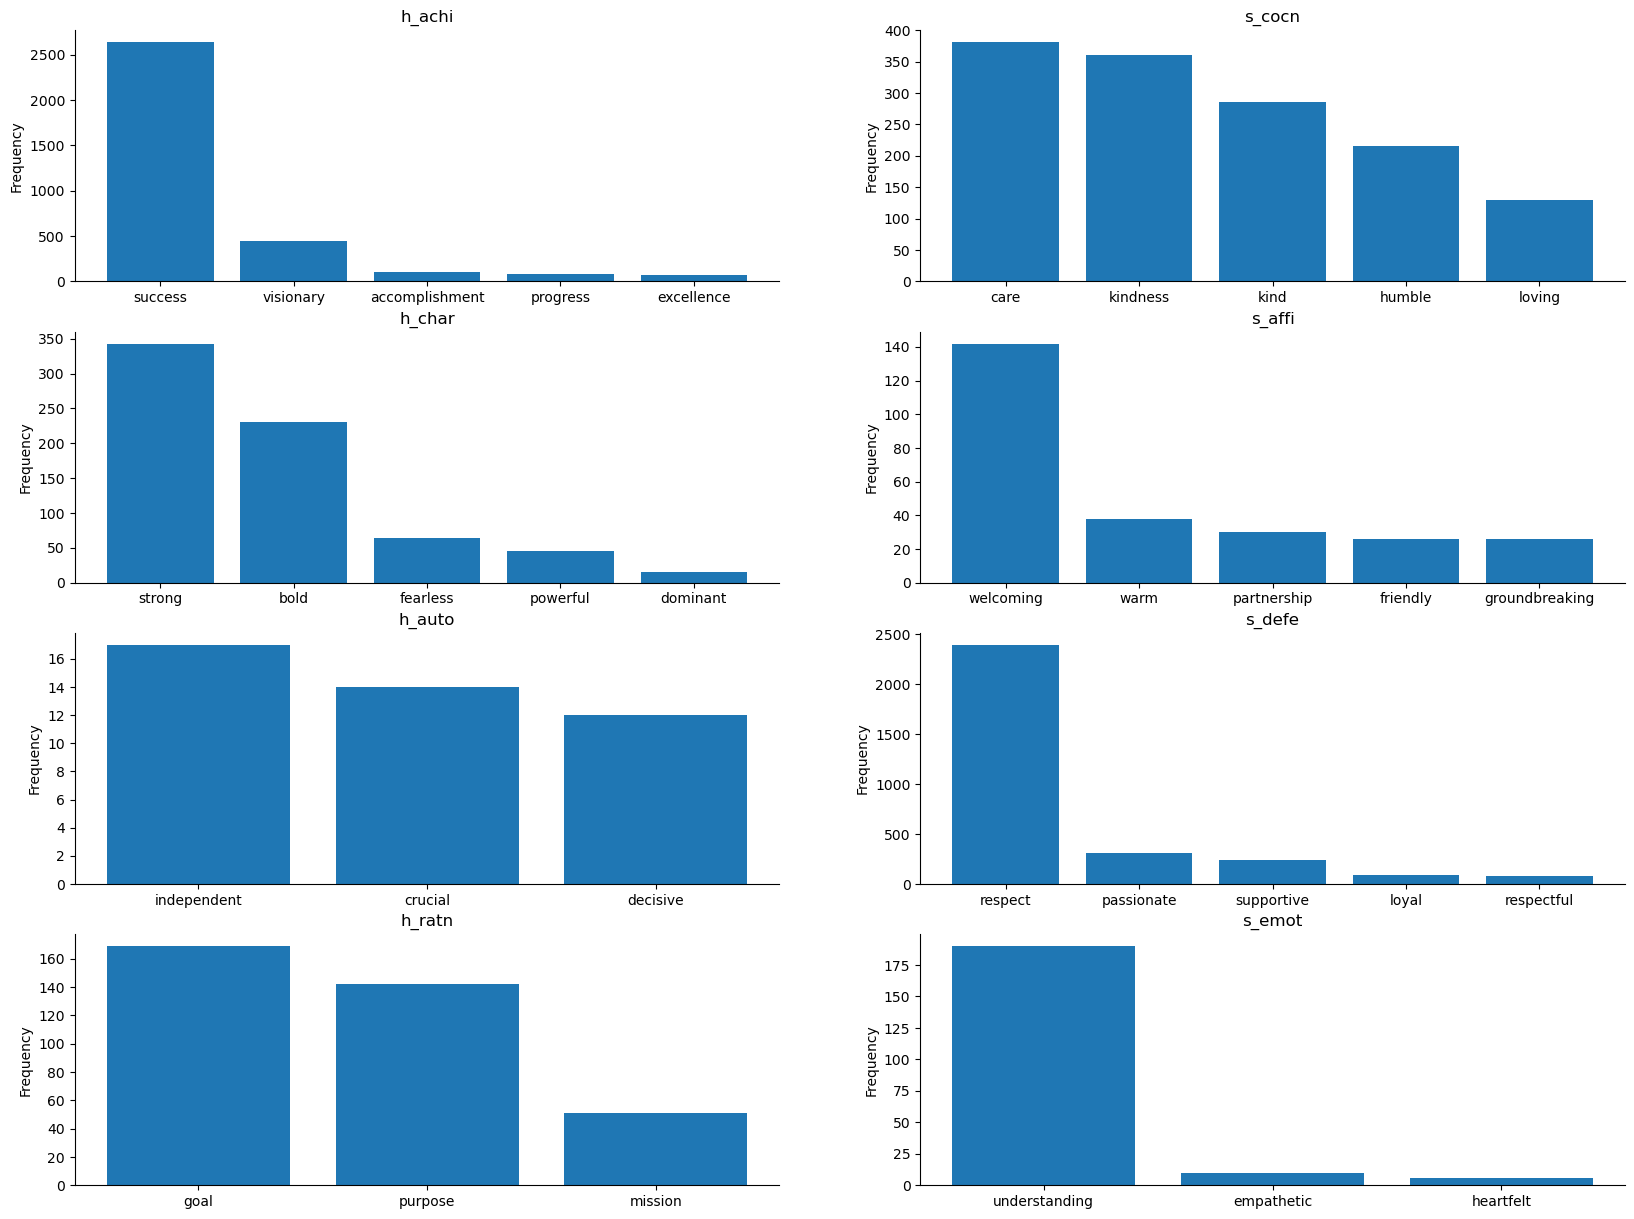

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15))

for i in range(4):
    for j in range(2):
        plot_dict = {k:freq_dict[k] for k in attr_dict_s[pairs[i+1][j]]}
        plot_dict = dict(sorted(plot_dict.items(), key=lambda x:x[1], reverse=True)[:5])
        axs[i,j].bar(*zip(*plot_dict.items()))
        axs[i,j].set_title(pairs[i+1][j])
        axs[i,j].spines[['top','right']].set_visible(False)  
        # axs[i,j].set_xlabel('Selected words')
        axs[i,j].set_ylabel('Frequency')

In [14]:
model = Word2Vec.load(f"{TRAINED_MODEL_NAME}.model")
word_vectors = model.wv
emp_model = WordEmbeddingModel(word_vectors, "sg_400")

#### 2.2 WEAT results between CEOs
I first ran 12 WEAT between 3 possible pairs of pronouns and 4 pairs of traits. As can be seen from the results below, 
- **3 out of the 12** WEAT are statistically significant with a p-value smaller than 0.05; 
- **male and female CEO** test results **do not show** that male CEOs are more associated with masculine traits, whereas female CEOs are the opposite;
- **non-binary CEOs** are associated with **feminine traits** like "Deference" and "Emotional sensitivity", as opposed to male CEOs' "Autonomy" and "Rationality". The inclination toward "Emotional sensitivity" in non-binary stories also holds true when the object of comparison turns into female CEOs. Such associations of feminine characteristics are not only statistically significant, but also substantively significant, as evidenced by effect size. 

In [15]:
for pair in pairs.values():
    query = Query([he_pns, she_pns],[attr_dict_s[pair[0]], attr_dict_s[pair[1]]],
                  ['he', 'she'], [pair[0],pair[1]])
    weat = WEAT()
    results = weat.run_query(query, emp_model, lost_vocabulary_threshold=0.4, calculate_p_value=True)

    print(results)

{'query_name': 'he and she wrt h_achi and s_cocn', 'result': -0.08286371330420184, 'weat': -0.08286371330420184, 'effect_size': -1.685986754472837, 'p_value': 0.9421487603305785}
{'query_name': 'he and she wrt h_char and s_affi', 'result': -0.10568332920471835, 'weat': -0.10568332920471835, 'effect_size': -1.3622699799521583, 'p_value': 0.9256198347107438}
{'query_name': 'he and she wrt h_auto and s_defe', 'result': 0.10909850522875797, 'weat': 0.10909850522875797, 'effect_size': -0.13397950924632582, 'p_value': 0.5785123966942148}
{'query_name': 'he and she wrt h_ratn and s_emot', 'result': -0.09194158017635351, 'weat': -0.09194158017635351, 'effect_size': -0.7240804550823213, 'p_value': 0.6694214876033058}


In [16]:
for pair in pairs.values():
    query = Query([he_pns, they_pns],[attr_dict_s[pair[0]], attr_dict_s[pair[1]]],
                  ['he', 'they'], [pair[0],pair[1]])
    weat = WEAT()
    results = weat.run_query(query, emp_model, lost_vocabulary_threshold=0.4, calculate_p_value=True)

    print(results)

{'query_name': 'he and they wrt h_achi and s_cocn', 'result': -0.19085278436541558, 'weat': -0.19085278436541558, 'effect_size': -1.5917727847065863, 'p_value': 0.9639389736477115}
{'query_name': 'he and they wrt h_char and s_affi', 'result': -0.2711452618241311, 'weat': -0.2711452618241311, 'effect_size': -1.7673747634151484, 'p_value': 0.9930651872399445}
{'query_name': 'he and they wrt h_auto and s_defe', 'result': 0.30771899744868286, 'weat': 0.30771899744868286, 'effect_size': 1.6116591311475053, 'p_value': 0.026352288488210817}
{'query_name': 'he and they wrt h_ratn and s_emot', 'result': 0.5647065117955208, 'weat': 0.5647065117955208, 'effect_size': 1.790336522530625, 'p_value': 0.020804438280166437}


In [17]:
for pair in pairs.values():
    query = Query([she_pns, they_pns],[attr_dict_s[pair[0]], attr_dict_s[pair[1]]],
                  ['she', 'they'], [pair[0],pair[1]])
    weat = WEAT()
    results = weat.run_query(query, emp_model, lost_vocabulary_threshold=0.4, calculate_p_value=True)

    print(results)

{'query_name': 'she and they wrt h_achi and s_cocn', 'result': -0.10798907106121375, 'weat': -0.10798907106121375, 'effect_size': -0.9657150615260117, 'p_value': 0.8099173553719008}
{'query_name': 'she and they wrt h_char and s_affi', 'result': -0.16546193261941278, 'weat': -0.16546193261941278, 'effect_size': -1.581304293582642, 'p_value': 0.9338842975206612}
{'query_name': 'she and they wrt h_auto and s_defe', 'result': 0.1986204922199249, 'weat': 0.1986204922199249, 'effect_size': 1.9615475996643599, 'p_value': 0.024793388429752067}
{'query_name': 'she and they wrt h_ratn and s_emot', 'result': 0.6566480919718742, 'weat': 0.6566480919718742, 'effect_size': 1.9991032137690143, 'p_value': 0.03305785123966942}


#### 2.3 WEAT results between same-gender roles
In addition to the association among CEOs, it is also interesting to **discover if there are any differences between same-gender CEOs and supporting characters**. This can be realized since pronouns for each of them are separated during preprocessing; for example, it is possible to compare the association between two sets of pronouns for "she" and "shee" in terms of a pair of traits. But such a comparison **cannot apply to non-binary people**, because "they" in the stories of male and female CEOs always refers to the plural form. Results below show that
- **Female** CEOs are more bonded to "Rationality", while female supporting characters relate to "Emotional sensitivity". This is a signal of **violation of prescriptive feminine stereotypes**, since as women, they should preserve the feminine "Emotional sensitivity" in female supporting roles. 
- For **male** CEOs and male marginal roles, there is **no significant pattern** of association.

In [18]:
shee_pns = ['shee', 'herr', 'herss']
hee_pns = ['hee', 'himm', 'hiss']
theyy_pns = ['theyy', 'theirr', 'themm']

In [19]:
for pair in pairs.values():
    query = Query([she_pns, shee_pns],[attr_dict_s[pair[0]], attr_dict_s[pair[1]]],
                  ['she', 'shee'], [pair[0],pair[1]])
    weat = WEAT()
    results = weat.run_query(query, emp_model, lost_vocabulary_threshold=0.4, calculate_p_value=True)

    print(results)

{'query_name': 'she and shee wrt h_achi and s_cocn', 'result': 0.010662782688935668, 'weat': 0.010662782688935668, 'effect_size': 0.4879533378832708, 'p_value': 0.4}
{'query_name': 'she and shee wrt h_char and s_affi', 'result': 0.10379418482383096, 'weat': 0.10379418482383096, 'effect_size': 1.7915407578630083, 'p_value': 0.04}
{'query_name': 'she and shee wrt h_auto and s_defe', 'result': -0.05743528405825299, 'weat': -0.05743528405825299, 'effect_size': -0.9193761813378429, 'p_value': 0.88}
{'query_name': 'she and shee wrt h_ratn and s_emot', 'result': 0.3902851094802221, 'weat': 0.3902851094802221, 'effect_size': 1.8170507639592166, 'p_value': 0.12}


In [20]:
for pair in pairs.values():
    query = Query([he_pns, hee_pns],[attr_dict_s[pair[0]], attr_dict_s[pair[1]]],
                  ['he', 'hee'], [pair[0],pair[1]])
    weat = WEAT()
    results = weat.run_query(query, emp_model, lost_vocabulary_threshold=0.7, calculate_p_value=True)

    print(results)

{'query_name': 'he and hee wrt h_achi and s_cocn', 'result': -0.05079034517208736, 'weat': -0.05079034517208736, 'effect_size': -1.7244123327615777, 'p_value': 1.0}
{'query_name': 'he and hee wrt h_char and s_affi', 'result': -0.09351244072119397, 'weat': -0.09351244072119397, 'effect_size': -0.5920151155635057, 'p_value': 0.72}
{'query_name': 'he and hee wrt h_auto and s_defe', 'result': 0.2271170022586982, 'weat': 0.2271170022586982, 'effect_size': -0.27119141249830164, 'p_value': 0.44}
{'query_name': 'he and hee wrt h_ratn and s_emot', 'result': 0.24930075307687127, 'weat': 0.24930075307687127, 'effect_size': 2.134122988642347, 'p_value': 0.12}


#### 2.4 the Relative Norm Distance (RND)
[RND](https://www.pnas.org/doi/10.1073/pnas.1720347115) estimates the strength of the relative association of a set of attribute words (A) in terms of two sets of target words (T_1,T_2 ). If v_a is a word vector of an attribute, v_1 and v_2 are average word vectors of two sets of target words, then RND is defined as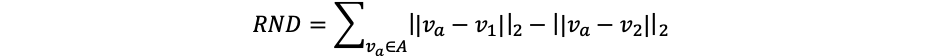

**When the RND value is large and positive, it means that the attribute set is more closely related to the second target set, whereas when it is large and negative, it means that the attribute set is more closely related to the first target set.**


The study used Relative Norm Distance to **conduct a more thorough analysis** after seeing that there are two pairs of comparisons (maleCEO v.s. femaleCEO, maleCEO v.s. maleSupportingCharacter) in the WEAT results that are not statistically significant. WEAT indicates that there is no association between male and female CEOs with respect to their relative differences in masculine and feminine traits, but it **does not mean that they are treated equally**. Since masculine and feminine traits here are not dichotomous, both are positive descriptors in the setting of the CEO story. **Insignificant results can also be caused by one of the targets holding dominant positions in both sets of traits.**

#### 2.5 RND results
Results from the Relative Norm Distance demonstrates that, surprisingly, 
- **male CEOs are the winners** of all eight groups of traits **compared to female CEOs**, as all RND are negative, meaning that eight traits are more associated with the first target; 
- **male CEOs** also have a stronger bond with **seven of the traits than male supporting characters.** Stories can evaluate male CEOs with a more demanding standard since they are associated with almost all traits compared to both female CEOs and male marginal characters.

In [21]:
l_group = ['h_achi', 'h_char', 'h_auto', 'h_ratn', 's_cocn', 's_affi', 's_defe', 's_emot']

In [22]:
for group in l_group:
    query = Query([he_pns, she_pns],[attr_dict_s[group]],
                  ['he', 'she'], [group])
    results = RND().run_query(query, emp_model, lost_vocabulary_threshold=0.4)

    print(results)

{'query_name': 'he and she wrt h_achi', 'result': -0.15973711013793945, 'rnd': -0.15973711013793945, 'distance_by_word': {'accomplishment': -0.31560755, 'ambition': -0.27576232, 'success': -0.25192118, 'achievement': -0.21657348, 'contribution': -0.20366049, 'visionary': -0.17954063, 'competent': -0.13629699, 'progress': -0.09606528, 'excellence': 0.0037095547, 'ambitious': 0.07434726}}
{'query_name': 'he and she wrt h_char', 'result': -0.061637679735819496, 'rnd': -0.061637679735819496, 'distance_by_word': {'fearless': -0.20138931, 'dominant': -0.17385077, 'vocal': -0.15040874, 'powerful': -0.023810387, 'bold': 0.010199785, 'strong': 0.16943336}}
{'query_name': 'he and she wrt h_auto', 'result': -0.19856890042622885, 'rnd': -0.19856890042622885, 'distance_by_word': {'crucial': -0.2700169, 'decisive': -0.24772453, 'independent': -0.07796526}}
{'query_name': 'he and she wrt h_ratn', 'result': -0.08936691284179688, 'rnd': -0.08936691284179688, 'distance_by_word': {'purpose': -0.27933788,

In [23]:
for group in l_group:
    query = Query([he_pns, hee_pns],[attr_dict_s[group]],
                  ['he', 'hee'], [group])
    results = RND().run_query(query, emp_model, lost_vocabulary_threshold=0.7)

    print(results)

{'query_name': 'he and hee wrt h_achi', 'result': -0.31529219150543214, 'rnd': -0.31529219150543214, 'distance_by_word': {'ambition': -0.90341234, 'excellence': -0.7703655, 'success': -0.45433283, 'ambitious': -0.42745137, 'visionary': -0.3033657, 'accomplishment': -0.22619152, 'progress': -0.20458698, 'competent': -0.022202492, 'achievement': 0.06684017, 'contribution': 0.092146635}}
{'query_name': 'he and hee wrt h_char', 'result': -0.2016895612080892, 'rnd': -0.2016895612080892, 'distance_by_word': {'fearless': -0.5527108, 'bold': -0.5249059, 'strong': -0.46674275, 'powerful': -0.070166826, 'dominant': 0.060414553, 'vocal': 0.34397435}}
{'query_name': 'he and hee wrt h_auto', 'result': -0.10151473681131999, 'rnd': -0.10151473681131999, 'distance_by_word': {'decisive': -0.62000895, 'independent': -0.13087058, 'crucial': 0.44633532}}
{'query_name': 'he and hee wrt h_ratn', 'result': -0.5173319180806478, 'rnd': -0.5173319180806478, 'distance_by_word': {'purpose': -0.74520755, 'mission'

### 3 Visualization check of the embedding space
Here is a visualization check as a complementary part of the analysis. The relationships between pronouns are learned by the model very well, as can be seem from the 2D plot after PCA below. Non-binary pronouns, "they/their/them", are spatially closer to feminine traits which are shown in purple.

In [24]:
biased_group = ['h_ratn', 'h_auto', 's_emot','s_defe']


biased_df = pd.DataFrame({'word': she_pns +he_pns +they_pns,\
                          'class':['she']*len(she_pns) +['he']*len(he_pns) +['they']*len(they_pns)})
for i in biased_group:
    single_df = pd.DataFrame({'word':list(attr_dict_s[i]),'class':[i]*len(attr_dict_s[i])})
    biased_df = pd.concat([biased_df, single_df], ignore_index=True)

In [25]:
biased_df = biased_df[biased_df.word != 'hers']
biased_df.index = biased_df['word'] 
X = word_vectors[biased_df.word]

In [26]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

In [27]:
biased_df['x_axis'] = X[:,0]
biased_df['y_axis'] = X[:,1]

In [28]:
biased_df.loc[(biased_df['class'] == 'h_ratn') | (biased_df['class'] == 'h_auto'),'class'] = 'h'
biased_df.loc[(biased_df['class'] == 's_defe') | (biased_df['class'] == 's_emot'),'class'] = 's'

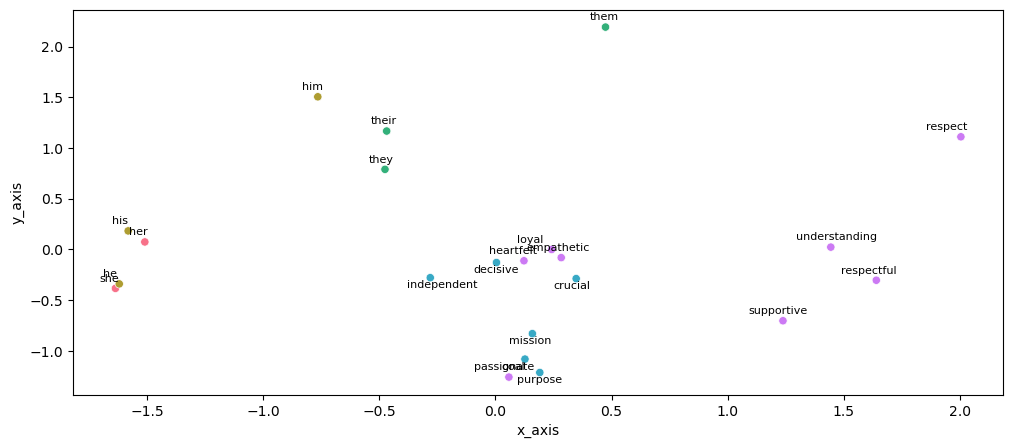

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(data=biased_df, x="x_axis", y="y_axis", hue="class", legend=False, palette='husl')
for i in biased_df[biased_df['class'] == 'h'].word:
    plt.annotate(i, (biased_df.loc[i,'x_axis']-0.1, biased_df.loc[i,'y_axis']-0.1), size=8)
for i in biased_df[biased_df['class'] == 's'].word:
    plt.annotate(i, (biased_df.loc[i,'x_axis']-0.15, biased_df.loc[i,'y_axis']+0.07), size=8)
for i in biased_df[:8].word:
    plt.annotate(i, (biased_df.loc[i,'x_axis']-0.07, biased_df.loc[i,'y_axis']+0.07), size=8)
